In [63]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
import math
import os
import seaborn as sns
import keras.backend as K
from keras import optimizers
from keras.layers import Dense
from keras.models import Sequential, load_model
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot
from datetime import datetime
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import pca
import xgboost
from xgboost import XGBRegressor
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from scipy import stats
from scipy.stats import norm, skew

seed = 2018

In [64]:
#简单模型融合
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # 遍历所有模型，你和数据
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X, y)

        return self
    
    # 预估，并对预估结果值做average
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        #return 0.85*predictions[:,0]+0.15*predictions[:,1]
        #return 0.7*predictions[:,0]+0.15*predictions[:,1]+0.15*predictions[:,2]
        return np.mean(predictions, axis=1)   


In [65]:
def load_train_data():
    df = pd.read_csv("zhengqi_train.txt", header=0, sep="\s+")
    #print(df.describe())
    X = df.drop(columns=["target"])
    y = df["target"]
    print("X shape:", X.shape)
    print("y shape", y.shape)
    #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    #print("X_train shape:", X_train.shape)
    #print("y_train shape:", y_train.shape)
    #print("X_val shape:", X_val.shape)
    #print("y_val shape:", y_val.shape)
    #return X_train, X_val, y_train, y_val
    return X, y

def load_test_data():
    df = pd.read_csv("zhengqi_test.txt", header=0, sep="\s+")
    #print(df.describe())
    X_test = df
    return X_test

In [66]:
def build_nn():
    model = Sequential()
    model.add(Dense(units=128, activation='linear', input_dim=18))
    model.add(Dense(units=32, activation='linear'))
    model.add(Dense(units=8, activation='linear'))
    model.add(Dense(units=1, activation='linear'))
    model.compile(loss='mse', optimizer='adam')
    return model
    
def build_model():
    svr = make_pipeline(SVR(kernel='linear'))
    line = make_pipeline(LinearRegression())
    lasso = make_pipeline(Lasso(alpha =0.0005, random_state=1))
    ENet = make_pipeline(ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
    KRR1 = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
    KRR2 = KernelRidge(alpha=1.5, kernel='linear', degree=2, coef0=2.5)    
    lgbm = lightgbm.LGBMRegressor(learning_rate=0.01, n_estimators=500, num_leaves=31)
    xgb = xgboost.XGBRegressor(booster='gbtree',colsample_bytree=0.8, gamma=0.1, 
                                 learning_rate=0.02, max_depth=5, 
                                 n_estimators=500,min_child_weight=0.8,
                                 reg_alpha=0, reg_lambda=1,
                                 subsample=0.8, silent=1,
                                 random_state =seed, nthread = 2)
    nn = KerasRegressor(build_fn=build_nn, nb_epoch=500, batch_size=32, verbose=2)
    return svr, line, lasso, ENet, KRR1, KRR2, lgbm, xgb, nn

In [67]:
def rmsle_cv(model=None,X_train_head=None,y_train=None):
    n_folds = 5
    kf = KFold(n_folds, shuffle=True, random_state=seed).get_n_splits(X_train_head)
    rmse= -cross_val_score(model, X_train_head, y_train, scoring="neg_mean_squared_error", cv = kf)
    return(rmse)

In [68]:
#load_dataset
with open("zhengqi_train.txt")  as fr:
    data_train=pd.read_table(fr,sep="\t")
with open("zhengqi_test.txt") as fr_test:
    data_test=pd.read_table(fr_test,sep="\t")
#merge train_set and test_set
data_train["oringin"]="train"
data_test["oringin"]="test"
data_all=pd.concat([data_train,data_test],axis=0,ignore_index=True)

In [69]:
# figure parameters
data_train1=data_all[data_all["oringin"]=="train"].drop("oringin",axis=1)
# Threshold for removing correlated variables
threshold = 0.1

# Absolute value correlation matrix
corr_matrix = data_train1.corr().abs()
drop_col=corr_matrix[corr_matrix["target"]<threshold].index
data_all.drop(drop_col,axis=1,inplace=True)

In [70]:
data_all.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V27,V28,V29,V30,V31,V35,V36,V37,target,oringin
0,0.566,0.016,-0.143,0.407,0.452,-0.901,-1.812,-2.360,-0.436,-2.114,...,0.168,-0.450,0.136,0.109,-0.615,-5.101,-2.608,-3.508,0.175,train
1,0.968,0.437,0.066,0.566,0.194,-0.893,-1.566,-2.360,0.332,-2.114,...,0.338,0.671,-0.128,0.124,0.032,0.364,-0.335,-0.730,0.676,train
2,1.013,0.568,0.235,0.370,0.112,-0.797,-1.367,-2.360,0.396,-2.114,...,0.326,1.287,-0.009,0.361,0.277,0.364,0.765,-0.589,0.633,train
3,0.733,0.368,0.283,0.165,0.599,-0.679,-1.200,-2.086,0.403,-2.114,...,0.277,1.298,0.015,0.417,0.279,0.364,0.333,-0.112,0.206,train
4,0.684,0.638,0.260,0.209,0.337,-0.454,-1.073,-2.086,0.314,-2.114,...,0.332,1.289,0.183,1.078,0.328,0.364,-0.280,-0.028,0.384,train


In [71]:
data_all.var()

V0        1.000025
V1        1.000031
V2        1.000015
V3        0.999990
V4        1.000030
V5        0.999992
V6        1.000069
V7        1.000059
V8        0.999989
V9        1.000513
V10       1.000034
V11       1.000054
V12       1.000027
V13       1.000004
V15       0.999996
V16       1.000001
V17       1.000198
V18       1.000010
V19       1.000167
V20       0.999982
V22       0.999910
V23       1.000006
V24       1.000369
V27       0.999999
V28       1.000062
V29       0.999993
V30       0.999987
V31       0.999997
V35       1.000123
V36       1.000038
V37       1.000034
target    0.968188
dtype: float64

In [72]:
data_all['V0_1']=data_all['V0']*data_all['V1']
data_all.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V28,V29,V30,V31,V35,V36,V37,target,oringin,V0_1
0,0.566,0.016,-0.143,0.407,0.452,-0.901,-1.812,-2.360,-0.436,-2.114,...,-0.450,0.136,0.109,-0.615,-5.101,-2.608,-3.508,0.175,train,0.009056
1,0.968,0.437,0.066,0.566,0.194,-0.893,-1.566,-2.360,0.332,-2.114,...,0.671,-0.128,0.124,0.032,0.364,-0.335,-0.730,0.676,train,0.423016
2,1.013,0.568,0.235,0.370,0.112,-0.797,-1.367,-2.360,0.396,-2.114,...,1.287,-0.009,0.361,0.277,0.364,0.765,-0.589,0.633,train,0.575384
3,0.733,0.368,0.283,0.165,0.599,-0.679,-1.200,-2.086,0.403,-2.114,...,1.298,0.015,0.417,0.279,0.364,0.333,-0.112,0.206,train,0.269744
4,0.684,0.638,0.260,0.209,0.337,-0.454,-1.073,-2.086,0.314,-2.114,...,1.289,0.183,1.078,0.328,0.364,-0.280,-0.028,0.384,train,0.436392


In [73]:
print(np.mean(data_all['V17']))

9.889881570743515e-05


In [74]:
#低相关度特征，分箱启用，将V17转化为bool型特征，是否大于当前均值
num1=np.mean(data_all['V17'])
data_all['V17_bool']=0
for i in range(len(data_all)):
    if data_all.loc[i]['V17']>=num1:
        data_all.loc[i,'V17_bool']=1

In [75]:
# function to detect outliers based on the predictions of a model
def find_outliers(model, X, y, sigma=3):

    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X,y)
        y_pred = pd.Series(model.predict(X), index=y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()

    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid)/std_resid    
    outliers = z[abs(z)>sigma].index
    
    # print and plot the results
    print('R2=',model.score(X,y))
    print("mse=",mean_squared_error(y,y_pred))
    print('---------------------------------------')

    print('mean of residuals:',mean_resid)
    print('std of residuals:',std_resid)
    print('---------------------------------------')

    print(len(outliers),'outliers:')
    print(outliers.tolist())

    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred');

    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.plot(y.loc[outliers],y.loc[outliers]-y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred');

    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    z.loc[outliers].plot.hist(color='r',bins=50,ax=ax_133)
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('z')
    
    plt.savefig('outliers.png')
    
    return outliers

In [76]:
# function to get training samples
def get_training_data():
    # extract training samples
    from sklearn.model_selection import train_test_split
    df_train = data_all[data_all["oringin"]=="train"]
    # split SalePrice and features
    y = df_train.target
    X = df_train.drop(["oringin","target"],axis=1)
    return X,y

# extract test data (without SalePrice)
def get_test_data():
    df_test = data_all[data_all["oringin"]=="test"].reset_index(drop=True)
    return df_test.drop(["oringin","target"],axis=1)

R2= 0.8895390893991936
mse= 0.10690995091968795
---------------------------------------
mean of residuals: 2.860131337676996e-17
std of residuals: 0.3270274949041703
---------------------------------------
30 outliers:
[321, 348, 777, 843, 884, 1069, 1178, 1310, 1458, 1523, 1704, 1874, 1972, 1979, 2002, 2264, 2279, 2528, 2620, 2645, 2647, 2667, 2668, 2669, 2696, 2697, 2769, 2807, 2842, 2863]


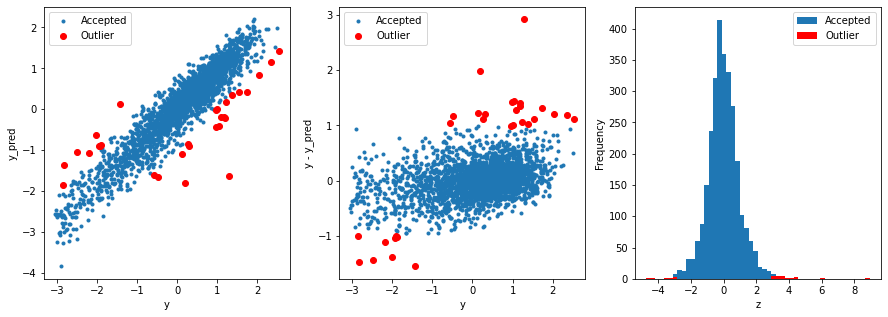

In [77]:
# get training data
from sklearn.linear_model import Ridge
X_train, y_train = get_training_data()
X_test=get_test_data()

# find and remove outliers using a Ridge model
outliers = find_outliers(Ridge(), X_train, y_train)

# permanently remove these outliers from the data
#df_train = data_all[data_all["oringin"]=="train"]
#df_train["label"]=data_train.target1
#df_train=df_train.drop(outliers)
X_outliers=X_train.loc[outliers]
y_outliers=y_train.loc[outliers]
X_t=X_train.drop(outliers)
y_t=y_train.drop(outliers)

In [78]:
X_t.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V27,V28,V29,V30,V31,V35,V36,V37,V0_1,V17_bool
0,0.566,0.016,-0.143,0.407,0.452,-0.901,-1.812,-2.360,-0.436,-2.114,...,0.168,-0.450,0.136,0.109,-0.615,-5.101,-2.608,-3.508,0.009056,0
1,0.968,0.437,0.066,0.566,0.194,-0.893,-1.566,-2.360,0.332,-2.114,...,0.338,0.671,-0.128,0.124,0.032,0.364,-0.335,-0.730,0.423016,0
2,1.013,0.568,0.235,0.370,0.112,-0.797,-1.367,-2.360,0.396,-2.114,...,0.326,1.287,-0.009,0.361,0.277,0.364,0.765,-0.589,0.575384,0
3,0.733,0.368,0.283,0.165,0.599,-0.679,-1.200,-2.086,0.403,-2.114,...,0.277,1.298,0.015,0.417,0.279,0.364,0.333,-0.112,0.269744,0
4,0.684,0.638,0.260,0.209,0.337,-0.454,-1.073,-2.086,0.314,-2.114,...,0.332,1.289,0.183,1.078,0.328,0.364,-0.280,-0.028,0.436392,0


In [79]:
def get_trainning_data_omitoutliers(X_t,y_t):
    y1=y_t.copy()
    X1=X_t.copy()
    return X1,y1

In [80]:
print(data_all.columns)

Index(['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V22',
       'V23', 'V24', 'V27', 'V28', 'V29', 'V30', 'V31', 'V35', 'V36', 'V37',
       'target', 'oringin', 'V0_1', 'V17_bool'],
      dtype='object')


In [86]:
def run(X_t,y_t,X_test):
    print("Load data from file......")
    X_train, y_train = get_trainning_data_omitoutliers(X_t,y_t)

    print("X_train shape", X_train.shape)
    print("X_test shape", X_test.shape)
    print("y_train shape", y_train.shape)
    all_data = pd.concat([X_train, X_test])
    print(all_data.shape)
    print("Load done.")
    # 异常值
    all_data = all_data.drop(["V5", "V9", "V11", "V17","V22", "V28"], axis=1)
    print(all_data.shape)
    print("Drop done.")
    # 标准化
    from sklearn import preprocessing
    scaler = MinMaxScaler(feature_range=(0,1))
    all_data = pd.DataFrame(scaler.fit_transform(all_data), columns=all_data.columns)
    print("Scale done.")
    all_data['V0'] = all_data['V0'].apply(lambda x:math.exp(x))
    all_data['V1'] = all_data['V1'].apply(lambda x:math.exp(x))
    #all_data['V4'] = all_data['V4'].apply(lambda x:math.exp(x))
    all_data['V6'] = all_data['V6'].apply(lambda x:math.exp(x))
    all_data['V7'] = all_data['V7'].apply(lambda x:math.exp(x))
    all_data['V8'] = all_data['V8'].apply(lambda x:math.exp(x))
    #all_data['V12'] = all_data['V12'].apply(lambda x:math.exp(x))
    #all_data['V16'] = all_data['V16'].apply(lambda x:math.exp(x))
    #all_data['V26'] = all_data['V26'].apply(lambda x:math.exp(x))
    #all_data['V27'] = all_data['V27'].apply(lambda x:math.exp(x))
    all_data["V30"] = np.log1p(all_data["V30"])
    #all_data["V31"] = np.log1p(all_data["V31"])
    #all_data["V32"] = np.log1p(all_data["V32"])
    #y_train = np.exp(y_train)
    scaled = pd.DataFrame(preprocessing.scale(all_data), columns = all_data.columns)
    X_train = scaled.loc[0:len(X_train)-1]
    X_test = scaled.loc[len(X_train):]
    print("y skew:", skew(y_train))
    print("Skewness done.")
    print("偏态后的shape", X_train.shape, X_test.shape, y_train.shape)
    #特征选择
    from sklearn.feature_selection import VarianceThreshold
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_regression
    #方差
    threshold = 0.85
    vt = VarianceThreshold().fit(X_train)
    # Find feature names
    feat_var_threshold = X_train.columns[vt.variances_ > threshold * (1-threshold)]
    X_train = X_train[feat_var_threshold]
    X_test = X_test[feat_var_threshold]
    all_data = pd.concat([X_train, X_test])
    print("方差后的shape", all_data.shape)
    #单变量
    X_scored = SelectKBest(score_func=f_regression, k='all').fit(X_train, y_train)
    feature_scoring = pd.DataFrame({
            'feature': X_train.columns,
            'score': X_scored.scores_
        })
    head_feature_num = 18
    feat_scored_headnum = feature_scoring.sort_values('score', ascending=False).head(head_feature_num)['feature']
    X_train_head = X_train[X_train.columns[X_train.columns.isin(feat_scored_headnum)]]
    X_scaled = pd.DataFrame(preprocessing.scale(X_train),columns = X_train.columns)
    X_test_head = X_test[X_test.columns[X_test.columns.isin(feat_scored_headnum)]]
    print("单变量选择后的shape")
    print(X_train_head.shape)
    print(y_train.shape)
    print(X_test_head.shape)
    print("Start training......")
    svr, line, lasso, ENet, KRR1, KRR2, lgbm, xgb, nn = build_model()
    train_start=datetime.now()
    score = rmsle_cv(svr, X_train_head, y_train)
    print("SVR 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
    svr.fit(X_train_head, y_train)
    score = rmsle_cv(line, X_train_head, y_train)
    print("Line 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
    score = rmsle_cv(lasso, X_train_head, y_train)
    print("Lasso 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
    score = rmsle_cv(ENet, X_train_head, y_train)
    print("ElasticNet 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
    score = rmsle_cv(KRR2, X_train_head, y_train)
    print("Kernel Ridge2 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
    KRR2.fit(X_train_head, y_train)
    # =============================================================================
    score = rmsle_cv(KRR1,X_train_head, y_train)
    print("Kernel Ridge1 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
    # =============================================================================
    head_feature_num = 22
    feat_scored_headnum = feature_scoring.sort_values('score', ascending=False).head(head_feature_num)['feature']
    X_train_head3 = X_train[X_train.columns[X_train.columns.isin(feat_scored_headnum)]]
    X_scaled = pd.DataFrame(preprocessing.scale(X_train),columns = X_train.columns)
    score = rmsle_cv(xgb,X_train_head3, y_train)
    print("Xgboost 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
    xgb.fit(X_train_head, y_train)
    # =============================================================================
    head_feature_num = 22
    feat_scored_headnum = feature_scoring.sort_values('score', ascending=False).head(head_feature_num)['feature']
    X_train_head4 = X_train[X_train.columns[X_train.columns.isin(feat_scored_headnum)]]
    X_scaled = pd.DataFrame(preprocessing.scale(X_train),columns = X_train.columns)
    score = rmsle_cv(lgbm,X_train_head4, y_train)
    print("LGBM 得分: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))
    lgbm.fit(X_train_head, y_train)
    # =============================================================================
    head_feature_num = 18
    feat_scored_headnum = feature_scoring.sort_values('score', ascending=False).head(head_feature_num)['feature']
    X_train_head5 = X_train[X_train.columns[X_train.columns.isin(feat_scored_headnum)]]
    X_scaled = pd.DataFrame(preprocessing.scale(X_train_head5),columns = X_train_head5.columns)
    score = rmsle_cv(nn,X_train_head5, y_train)
    print("NN 得分: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))
    nn.fit(X_train_head, y_train)
    # =============================================================================
    averaged_models = AveragingModels(models = (svr,KRR2,lgbm,nn))
    score = rmsle_cv(averaged_models, X_train_head, y_train)
    print("对基模型集成后的得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
    averaged_models.fit(X_train_head, y_train)
    
    train_end=datetime.now()
    print('spend time:'+ str((train_end-train_start).seconds)+'(s)')

    print("Predict......")
    y_pred = averaged_models.predict(X_test_head)
    result = pd.DataFrame(y_pred)
    result.to_csv("result(averaged_test_1).txt", index=False, header=False)
    print("Predict Done.")
    print(datetime.now())
    



In [91]:
run(X_t,y_t,X_test)

Load data from file......
X_train shape (2858, 33)
X_test shape (1925, 33)
y_train shape (2858,)
(4783, 33)
Load done.
(4783, 27)
Drop done.
Scale done.
y skew: -0.9071354737417406
Skewness done.
偏态后的shape (2858, 27) (1925, 27) (2858,)
方差后的shape (4783, 26)
单变量选择后的shape
(2858, 18)
(2858,)
(1925, 18)
Start training......
SVR 得分: 0.1070 (0.0184)

Line 得分: 0.1081 (0.0166)

Lasso 得分: 0.1079 (0.0169)

ElasticNet 得分: 0.1079 (0.0169)

Kernel Ridge2 得分: 0.1070 (0.0168)

Kernel Ridge1 得分: 0.1067 (0.0162)

[11:07:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:08:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: {